<center>
<h1>Fake news detection using graph neural network</h1>
<h2>Creation of the dataset</h2>
<i><h6>Victor GOUBET | Nicholas Tagliapietra | Asma Bakhtiariazad</h6></i>
</center>


----

# Library

In [1]:
import os
import torch
import numpy as np
import pickle as pk
import os.path as osp
import networkx as nx
import scipy.sparse as sp
import matplotlib.pyplot as plt

from torch_sparse import coalesce
from torch_geometric.io import read_txt_array
from torch_geometric.utils.convert import to_networkx
from torch_geometric.data import Data, InMemoryDataset
from google_drive_downloader import GoogleDriveDownloader as gdd

# Define features computation

In [2]:
class features_box():

    # GRAPH
    def g_avg_dg(G):
        return np.mean([d for _, d in G.degree()])

    def g_std_dg(G):
        return np.std([d for _, d in G.degree()])

    def g_root_dg(G):
        return G.degree()[0]
    
    def g_root_cc(G):
        return nx.closeness_centrality(G, 0)
    
    def g_max_cc(G):
        return max(nx.closeness_centrality(G).values())
    
    def g_max_bc(G):
        return max(nx.betweenness_centrality(G).values())
        

    # NODE
    def n_cc(G):
        return list(nx.closeness_centrality(G).values())

    def n_bc(G):
        return list(nx.betweenness_centrality(G).values())
    
    def n_dg(G):
        return list(dict(G.degree()).values())

In [3]:
nodes_f = {n:f for n, f in features_box.__dict__.items() if n[:2] == 'n_'}
graphs_f = {n:f for n, f in features_box.__dict__.items() if n[:2] == 'g_'}

# Define the dataset class

In [4]:
class ext_UPFD(InMemoryDataset):

    ids = {
        'politifact': '1KOmSrlGcC50PjkvRVbyb_WoWHVql06J-',
        'gossipcop': '1VskhAQ92PrT4sWEKQ2v2-AJhEcpp4A81',
    }

    def __init__(self, name, root, n_features=[], g_features=[], split="train", transform=None):
        
        self.name = name
        self.root = root
        self.source = 'gossipcop'
        self.raw_feature = 'profile'
        self.n_features = n_features
        self.g_features = g_features
        super().__init__(root, transform, None, None)

        assert split in ['train', 'val', 'test']
        path = self.processed_paths[['train', 'val', 'test'].index(split)]
        self.data, self.slices = torch.load(path)

    @property
    def raw_dir(self):
        return osp.join(self.root, self.source, 'raw')

    @property
    def processed_dir(self):
        return osp.join(self.root, self.source, 'processed', self.raw_feature)

    @property
    def raw_file_names(self):
        return [
            'node_graph_id.npy', 'graph_labels.npy', 'A.txt', 'train_idx.npy',
            'val_idx.npy', 'test_idx.npy', f'new_{self.raw_feature}_feature.npz'
        ]

    @property
    def processed_file_names(self):
        return [f'train_{self.name}.pt', 
                f'val_{self.name}.pt', 
                f'test_{self.name}.pt']

    def download(self):
        gdd.download_file_from_google_drive(
            self.ids[self.source], osp.join(self.raw_dir, f'{self.source}.zip'),
            unzip=True)
        os.remove(osp.join(self.raw_dir, f'{self.source}.zip'))
    
    def get_n_features(self, G):
        # We have to calculate the new features for each node in the matrix x
        n_features = []

        for ft, fct in nodes_f.items():
            ft_i = []
            if ft in self.n_features:
                for g in G:
                    ft_i += fct(g)
                n_features.append(ft_i)
        n_features = np.transpose(np.asarray(n_features))
        return torch.Tensor(n_features)
    
    def get_g_features(self, G):
        # for each graph we have to compute the graph features
        g_features = []

        for ft, fct in graphs_f.items():
            ft_i = []
            if ft in self.g_features:
                for g in G:
                    ft_i.append(fct(g))
                g_features.append(ft_i)
        g_features = np.asarray(g_features)
        return torch.Tensor(g_features)
    
    def add_new_features(self, x, y):
        
        G = [to_networkx(x) for x in self]
        
        new_n_features = self.get_n_features(G)
        x_new = x.type(torch.float32) if len(new_n_features) == 0 else torch.concat([x, new_n_features], axis=1)
        
        new_g_features = self.get_g_features(G)
        y_new = y.reshape(-1, 1).type(torch.float32) if len(new_g_features) == 0 else torch.t(torch.vstack([y, new_g_features]))
        
        changed = len(new_n_features) != 0 or len(new_g_features) != 0
        return x_new, y_new, changed

    def process(self):
        
        # Download raw data
        x, y, batch, edge_index = self.load_raw()
        
        # Set the slices for the nodes
        node_slice = self.set_slices(batch, edge_index, y)
        edge_index -= node_slice[batch[edge_index[0]]].view(1, -1)
        
        # Initiate the graph dataset
        self.data = Data(x=x, edge_index=edge_index, y=y)
        
        # Compute new features and add them
        x_new, y_new, changed = self.add_new_features(x, y)
        self.data = Data(x=x_new, edge_index=edge_index, y=y_new) 
        
        
        # Actualize the graph dataset
        for path, split in zip(self.processed_paths, ['train', 'val', 'test']):
            idx = np.load(osp.join(self.raw_dir, f'{split}_idx.npy')).tolist()
            
            n_g_id = np.load(osp.join(self.raw_dir, 'node_graph_id.npy'))
            data_list = []

            for i in idx:
            
                graph = self.get(i)
                x_idx = np.argwhere(n_g_id == i).flatten()
                x_feat = x_new[x_idx, :]
                y_feat = torch.unsqueeze(y_new[i, :], 0)

                datum = Data(x=x_feat, edge_index=graph.edge_index, y=y_feat)
                data_list.append(datum)
        
            torch.save(self.collate(data_list), path)
            
    def load_raw(self):
        
        x = sp.load_npz(
            osp.join(self.raw_dir, f'new_{self.raw_feature}_feature.npz'))
        x = torch.from_numpy(x.todense()).to(torch.float)

        edge_index = read_txt_array(osp.join(self.raw_dir, 'A.txt'), sep=',',
                                    dtype=torch.long).t()
        edge_index, _ = coalesce(edge_index, None, x.size(0), x.size(0))

        y = np.load(osp.join(self.raw_dir, 'graph_labels.npy'))
        y = torch.from_numpy(y).to(torch.long)
        _, y = y.unique(sorted=True, return_inverse=True)

        batch = np.load(osp.join(self.raw_dir, 'node_graph_id.npy'))
        batch = torch.from_numpy(batch).to(torch.long)
        
        return x, y, batch, edge_index

    def set_slices(self, batch, edge_index, y):
        
        node_slice = torch.cumsum(batch.bincount(), 0)
        node_slice = torch.cat([torch.tensor([0]), node_slice])
        edge_slice = torch.cumsum(batch[edge_index[0]].bincount(), 0)
        edge_slice = torch.cat([torch.tensor([0]), edge_slice])
        graph_slice = torch.arange(y.size(0) + 1)
        self.slices = {
            'x': node_slice,
            'edge_index': edge_slice,
            'y': graph_slice
        }
        return node_slice

    def __repr__(self):
        return (f'{self.__class__.__name__}({len(self)}, name={self.source}, '
                f'raw_feature={self.raw_feature}, node feature={self.n_features}, '
                f'graph feature={self.g_features})')

# Create data

In [11]:
path = '../data/'

In [12]:
origin_train = ext_UPFD('original', path, split='train')
origin_val = ext_UPFD('original', path, split='val')
origin_test = ext_UPFD('original', path, split='test')

In [13]:
n_ft = ['n_dg', 'n_cc']
g_ft = ['g_avg_dg', 'g_root_dg']
data1_train = ext_UPFD('data1', path, n_ft, g_ft, split='train')
data1_val = ext_UPFD('data1', path, n_ft, g_ft, split='val')
data1_test = ext_UPFD('data1', path, n_ft, g_ft, split='test')

In [14]:
n_ft = ['n_dg', 'n_cc', 'n_bc']
g_ft = ['g_avg_dg', 'g_std_dg', 'g_root_dg', 'g_root_cc', 'g_max_cc', 'g_max_bc']

data2_train = ext_UPFD('data2', path, n_ft, g_ft, split='train')
data2_val = ext_UPFD('data2', path, n_ft, g_ft, split='val')
data2_test = ext_UPFD('data2', path, n_ft, g_ft, split='test')

In [15]:
datasets = [('origin', origin_train, origin_val, origin_test),
            ('dataset1', data1_train, data1_val, data1_test),
            ('dataset2', data2_train, data2_val, data2_test)]

pk.dump(datasets, open(f'{path}datasets.pkl', 'wb'))

In [17]:
datasets = pk.load(open(f'{path}datasets.pkl', 'rb'))

# Show data

In [20]:
def plot_minigraph(n, dataset):

    nx_g = {'true':[], 'false':[]}
    for x in dataset:
        if x.y[0, 0]:
            nx_g['true'] += [to_networkx(x)]
        else:
            nx_g['false'] += [to_networkx(x)]

    
    for k in range(n):
        col1 = [1] + [0 for _ in range(len(nx_g['true'][k].nodes)-1)]
        col2 = [1] + [0 for _ in range(len(nx_g['false'][k].nodes)-1)]

        plt.figure(1, figsize=(16, 8)) 
        plt.subplot(1, 2, 1)
        nx.draw(nx_g['true'][k], node_size=75, linewidths=6, node_color=col1)
        plt.subplot(1, 2, 2)
        nx.draw(nx_g['false'][k], node_size=75, linewidths=6, node_color=col2)
        plt.show()

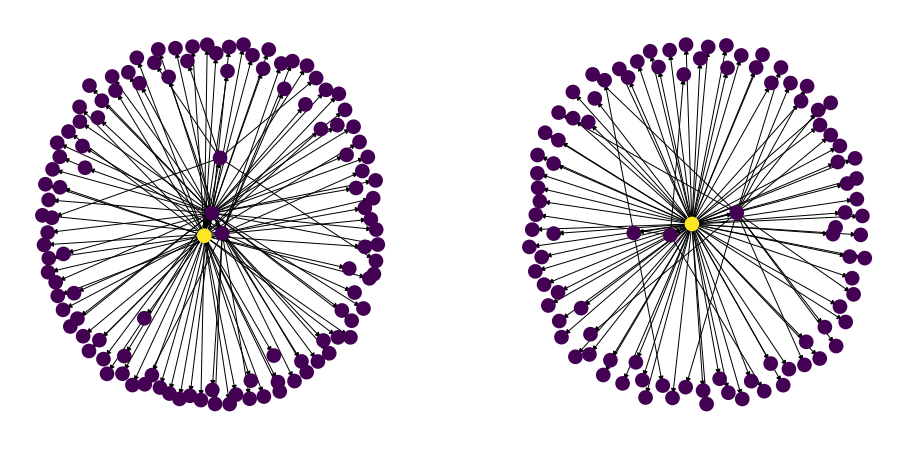

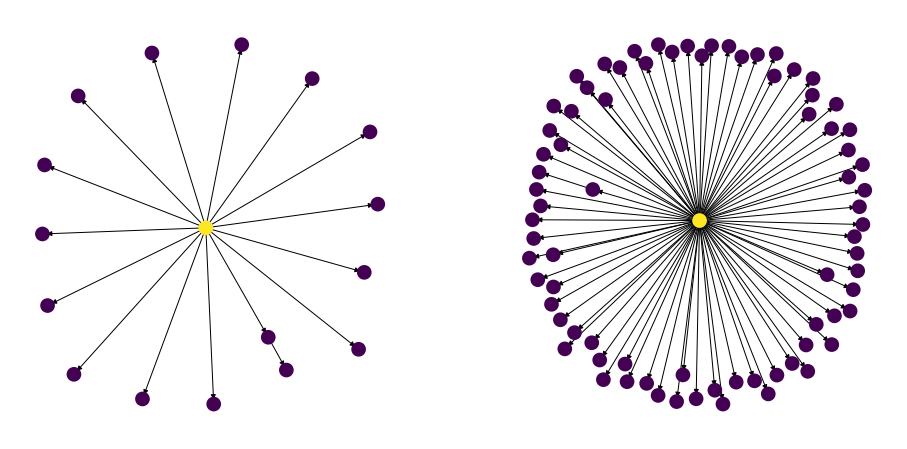

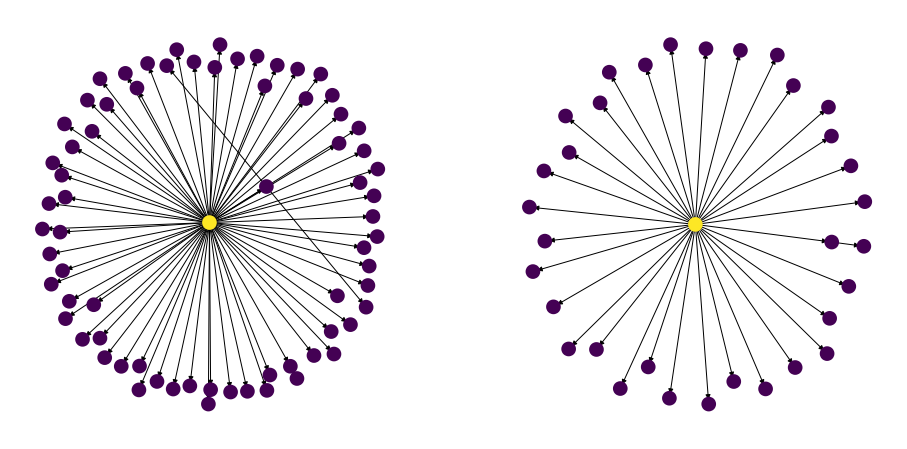

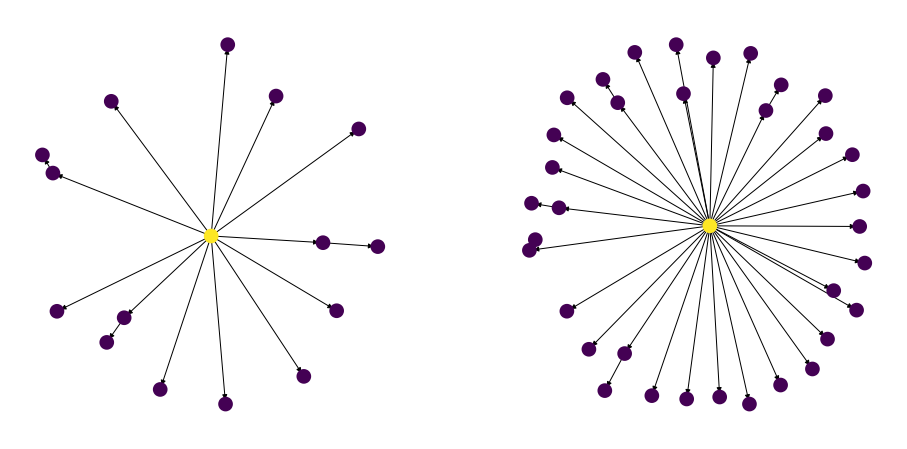

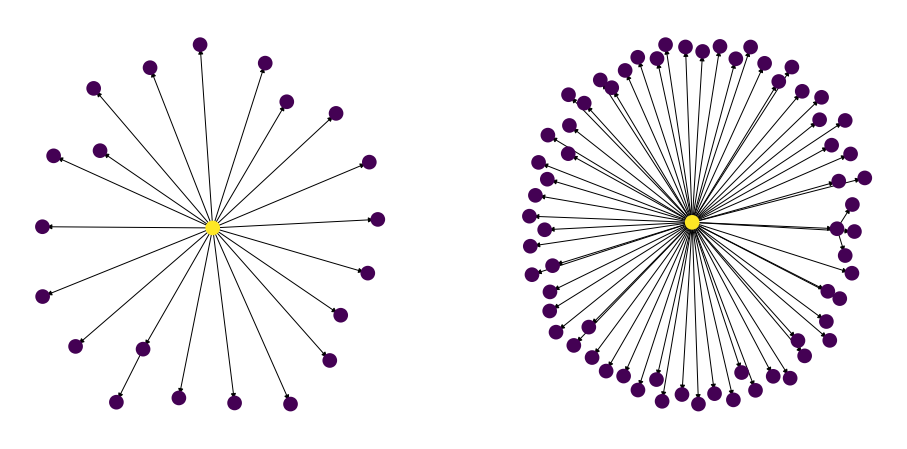

In [22]:
plot_minigraph(5, datasets[-1][-1])